# EDA Default Payment Next Month (clasificación)

## Importación de librerías

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats.mstats import winsorize

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    AdaBoostClassifier, ExtraTreesClassifier
)
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, roc_curve, 
    roc_auc_score
)

from sklearn.metrics import make_scorer
from tqdm import tqdm

In [2]:
df = pd.read_excel('../data/01_raw/default of credit card clients.xls', header=[1])
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [5]:
df.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0


default payment next month
0    0.7788
1    0.2212
Name: proportion, dtype: float64


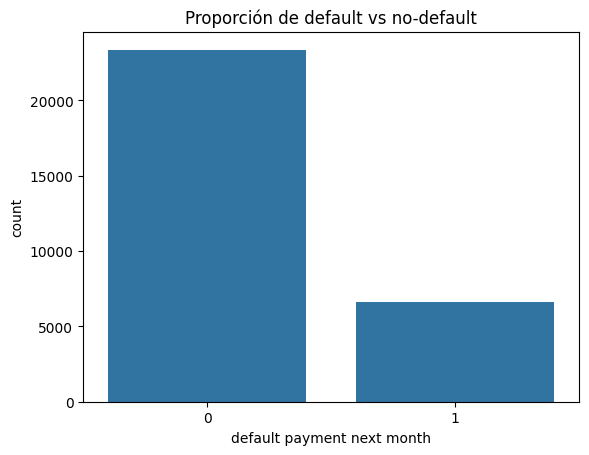

In [3]:
print(df['default payment next month'].value_counts(normalize=True))
sns.countplot(x='default payment next month', data=df)
plt.title("Proporción de default vs no-default")
plt.show()

<Axes: xlabel='SEX', ylabel='count'>

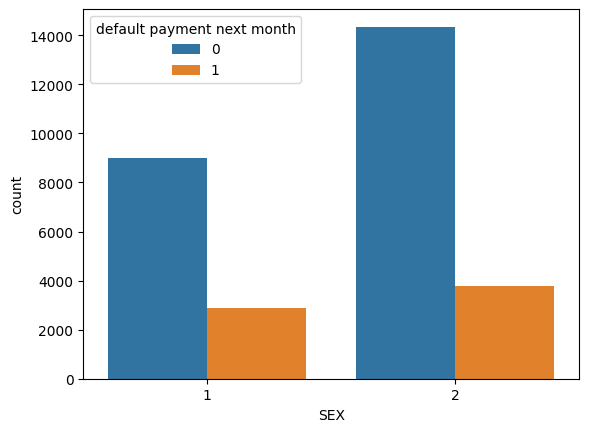

In [7]:
sns.countplot(x='SEX', hue='default payment next month', data=df)

In [9]:
df['EDUCATION'] = df['EDUCATION'].replace({0:4, 5:4, 6:4})
df['MARRIAGE'] = df['MARRIAGE'].replace({0:3})

<Axes: xlabel='EDUCATION', ylabel='count'>

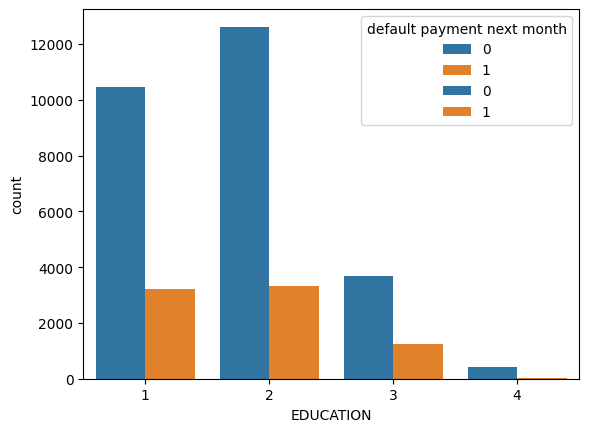

In [10]:
sns.countplot(x='EDUCATION', hue='default payment next month', data=df)
sns.countplot(x='MARRIAGE', hue='default payment next month', data=df)

<Axes: xlabel='AGE', ylabel='Count'>

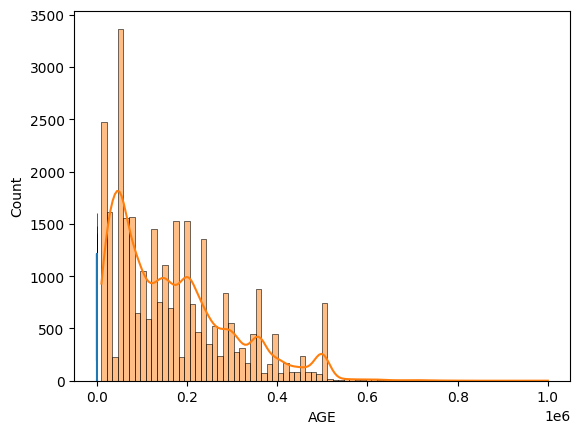

In [11]:
sns.histplot(df['AGE'], kde=True)
sns.histplot(df['LIMIT_BAL'], kde=True)

<Axes: xlabel='default payment next month', ylabel='LIMIT_BAL'>

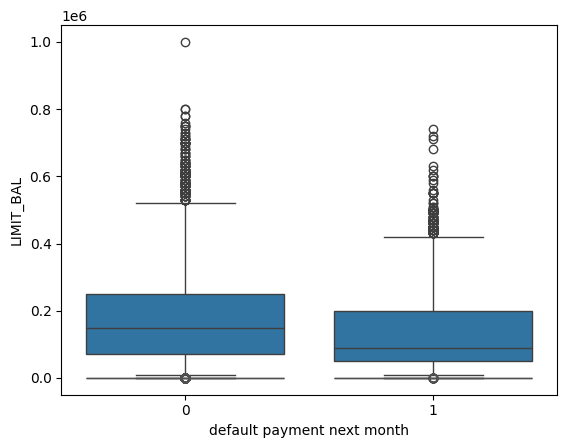

In [12]:
sns.boxplot(x='default payment next month', y='LIMIT_BAL', data=df)
sns.boxplot(x='default payment next month', y='AGE', data=df)

In [16]:
pay_cols = [f"PAY_{i}" for i in [0,2,3,4,5,6]]
df[pay_cols].describe()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100
std,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


<Axes: >

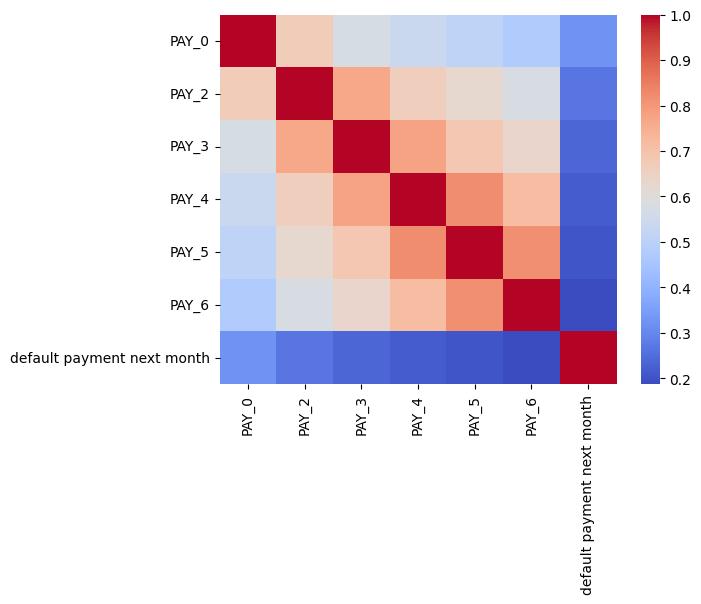

In [17]:
sns.heatmap(df[pay_cols + ['default payment next month']].corr(), annot=False, cmap='coolwarm')

In [18]:
bill_cols = [f"BILL_AMT{i}" for i in range(1,7)]
pay_cols2 = [f"PAY_AMT{i}" for i in range(1,7)]

df[bill_cols].describe()
df[pay_cols2].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


In [19]:
df[bill_cols + ['default payment next month']].corr()['default payment next month']
df[pay_cols2 + ['default payment next month']].corr()['default payment next month']

PAY_AMT1                     -0.072929
PAY_AMT2                     -0.058579
PAY_AMT3                     -0.056250
PAY_AMT4                     -0.056827
PAY_AMT5                     -0.055124
PAY_AMT6                     -0.053183
default payment next month    1.000000
Name: default payment next month, dtype: float64

## Preprocesamiento

In [3]:
df.rename(columns={"default payment next month": "default"}, inplace=True)

df["EDUCATION"] = df["EDUCATION"].replace({0:4, 5:4, 6:4})
df["MARRIAGE"]  = df["MARRIAGE"].replace({0:3})


allowed_cols_default = [
    "LIMIT_BAL","SEX","EDUCATION","MARRIAGE","AGE",
    "PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6",
    "BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6",
    "PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6",
]

winsor_cols = [
    "BILL_AMT2","BILL_AMT3","BILL_AMT4","BILL_AMT5","BILL_AMT6",
    "PAY_AMT2","PAY_AMT3","PAY_AMT4","PAY_AMT5","PAY_AMT6",
]

for col in winsor_cols:
    df[col] = winsorize(df[col], limits=[0.01, 0.01])


# Retrasos
pay_cols = ["PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]
df["delay_sum"] = df[pay_cols].clip(lower=0).sum(axis=1)
df["delay_count"] = (df[pay_cols] > 0).sum(axis=1)
df["max_delay"] = df[pay_cols].max(axis=1)

# Ratios de pago
for i in [2,3,4,5,6]:
    df[f"pay_ratio_{i}"] = df[f"PAY_AMT{i}"] / (df[f"BILL_AMT{i}"] + 1)

ratio_cols = [f"pay_ratio_{i}" for i in [2,3,4,5,6]]
df["avg_pay_ratio"] = df[ratio_cols].mean(axis=1)
df["min_pay_ratio"] = df[ratio_cols].min(axis=1)
df["max_pay_ratio"] = df[ratio_cols].max(axis=1)

# Tendencias
df["bill_trend"] = df["BILL_AMT2"] - df["BILL_AMT6"]
df["pay_trend"]  = df["PAY_AMT2"] - df["PAY_AMT6"]


final_cols = allowed_cols_default + [
    "delay_sum","delay_count","max_delay",
    "avg_pay_ratio","min_pay_ratio","max_pay_ratio",
    "bill_trend","pay_trend"
]

df_clean = df[final_cols + ["default"]].fillna(0)

## Selección y Comparación de Modelos

Se implementan múltiples algoritmos de clasificación:

- Modelos lineales y basados en vecinos: Logistic Regression (con escalado), KNN (con escalado)
- Ensambladores de árboles: Random Forest, Gradient Boosting, AdaBoost, Extra Trees, XGBoost
- Árbol de decisión individual como baseline

Se aplican métricas de evaluación con validación cruzada 5-fold:

- **AUC (Área bajo la curva ROC)**
- **Accuracy**
- **Precision**
- **Recall**
- **F1-score**



In [4]:
X = df_clean.drop(columns=["default"])
y = df_clean["default"]

In [5]:
scaled_models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(max_iter=2000))
    ]),
    'KNN': Pipeline([
        ('scaler', StandardScaler()),
        ('model', KNeighborsClassifier())
    ])
}

tree_models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Extra Trees': ExtraTreesClassifier(random_state=42),
    'XGBoost': XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
}

classifiers = {**scaled_models, **tree_models}

scoring = {
    "AUC": "roc_auc",
    "Accuracy": make_scorer(accuracy_score),
    "Precision": make_scorer(precision_score),
    "Recall": make_scorer(recall_score),
    "F1": make_scorer(f1_score),
}

results = {}

for name, model in tqdm(classifiers.items(), desc="Evaluando Modelos"):
    results[name] = {}
    for metric_name, metric in tqdm(scoring.items(), desc=f"Evaluando métricas para {name}"):
        scores = cross_val_score(model, X, y, cv=5, scoring=metric)
        results[name][metric_name] = scores


auc_df     = pd.DataFrame({m: results[m]["AUC"] for m in classifiers.keys()})
acc_df     = pd.DataFrame({m: results[m]["Accuracy"] for m in classifiers.keys()})
prec_df    = pd.DataFrame({m: results[m]["Precision"] for m in classifiers.keys()})
recall_df  = pd.DataFrame({m: results[m]["Recall"] for m in classifiers.keys()})
f1_df      = pd.DataFrame({m: results[m]["F1"] for m in classifiers.keys()})


auc_rank = auc_df.mean().sort_values(ascending=False)
auc_rank

Evaluando Modelos:  88%|████████▊ | 7/8 [06:20<00:51, 51.98s/it]/Users/davidclemente/Dropbox/2025/Bluetab/bluetab-test/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:45:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/davidclemente/Dropbox/2025/Bluetab/bluetab-test/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:45:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/davidclemente/Dropbox/2025/Bluetab/bluetab-test/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:45:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/davidclemente/Dropbox/2025/Bluet

Gradient Boosting      0.781358
AdaBoost               0.772773
XGBoost                0.760928
Random Forest          0.757044
Logistic Regression    0.756918
Extra Trees            0.747433
KNN                    0.703404
Decision Tree          0.613162
dtype: float64

In [7]:
# Imprimir cada dataframe por métrica

print("Dataframe de AUC:")
display(auc_df)

print("\nDataframe de Accuracy:")
display(acc_df)

print("\nDataframe de Precision:")
display(prec_df)

print("\nDataframe de Recall:")
display(recall_df)

print("\nDataframe de F1:")
display(f1_df)

Dataframe de AUC:


,Logistic Regression,KNN,Random Forest,Gradient Boosting,Decision Tree,AdaBoost,Extra Trees,XGBoost
0,0.737220,0.681887,0.736621,0.756235,0.605057,0.748086,0.726071,0.731505
1,0.736105,0.696250,0.736048,0.755819,0.610341,0.751167,0.729447,0.747057
2,0.759383,0.713196,0.773064,0.791202,0.612874,0.780110,0.759359,0.765694
3,0.776748,0.718541,0.773197,0.802557,0.619511,0.793883,0.764538,0.786702
4,0.775137,0.707148,0.766288,0.800975,0.618027,0.790621,0.757752,0.773680



Dataframe de Accuracy:


,Logistic Regression,KNN,Random Forest,Gradient Boosting,Decision Tree,AdaBoost,Extra Trees,XGBoost
0,0.798833,0.783000,0.802500,0.805667,0.715333,0.806500,0.797167,0.795500
1,0.801500,0.782000,0.806000,0.812167,0.721000,0.811167,0.798667,0.803333
2,0.808167,0.794500,0.818833,0.821667,0.714000,0.825000,0.816333,0.810833
3,0.814500,0.798000,0.826000,0.832833,0.734667,0.829000,0.821000,0.823167
4,0.818333,0.797167,0.818000,0.826000,0.731167,0.824667,0.812000,0.817667



Dataframe de Precision:


,Logistic Regression,KNN,Random Forest,Gradient Boosting,Decision Tree,AdaBoost,Extra Trees,XGBoost
0,0.601681,0.515152,0.593220,0.615714,0.369863,0.634895,0.571429,0.566711
1,0.610032,0.510638,0.603034,0.636986,0.379764,0.651563,0.568000,0.594839
2,0.632132,0.549788,0.641509,0.658446,0.373455,0.691034,0.624585,0.612676
3,0.698885,0.569528,0.694635,0.735465,0.402788,0.742351,0.670715,0.688920
4,0.724858,0.569975,0.664336,0.714719,0.396825,0.732657,0.638773,0.667145



Dataframe de Recall:


,Logistic Regression,KNN,Random Forest,Gradient Boosting,Decision Tree,AdaBoost,Extra Trees,XGBoost
0,0.269578,0.332831,0.342620,0.324548,0.406627,0.295934,0.334337,0.323042
1,0.284099,0.343632,0.359457,0.350414,0.412962,0.314243,0.374529,0.347400
2,0.317257,0.391108,0.409947,0.402411,0.432555,0.377543,0.425019,0.393369
3,0.283346,0.354936,0.380558,0.381311,0.413715,0.347400,0.374529,0.365486
4,0.287867,0.337604,0.357950,0.354936,0.414469,0.326300,0.345139,0.350414



Dataframe de F1:


,Logistic Regression,KNN,Random Forest,Gradient Boosting,Decision Tree,AdaBoost,Extra Trees,XGBoost
0,0.372335,0.404392,0.434368,0.425049,0.387374,0.403698,0.421853,0.411511
1,0.387661,0.410811,0.450425,0.452115,0.395668,0.423996,0.451408,0.438630
2,0.422479,0.457067,0.500230,0.499532,0.400838,0.488304,0.505830,0.479119
3,0.403217,0.437326,0.491723,0.502233,0.408178,0.473306,0.480658,0.477597
4,0.412082,0.424042,0.465230,0.474320,0.405455,0.451512,0.448141,0.459486


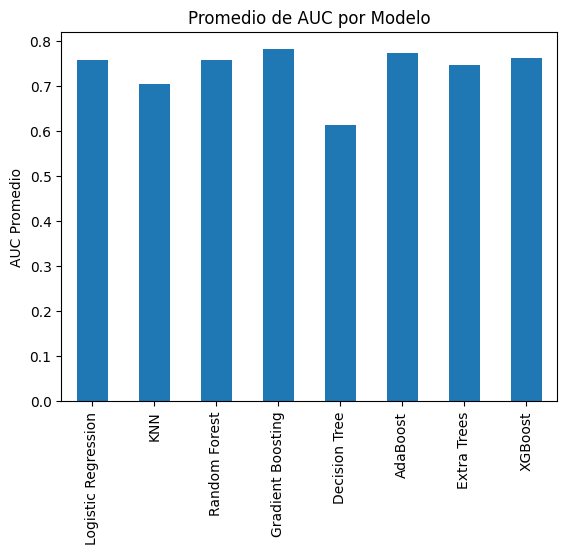

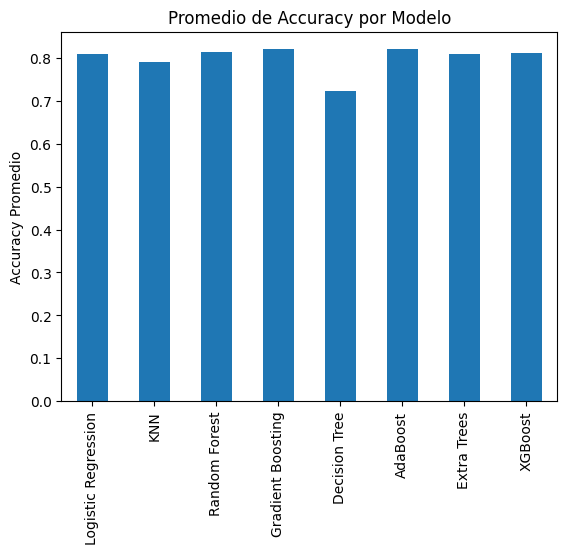

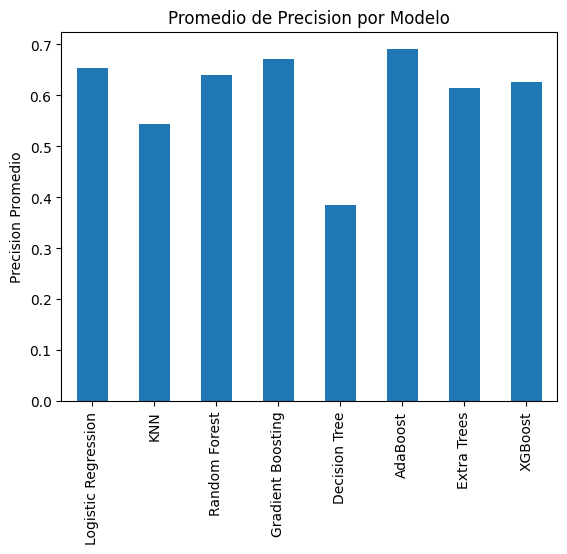

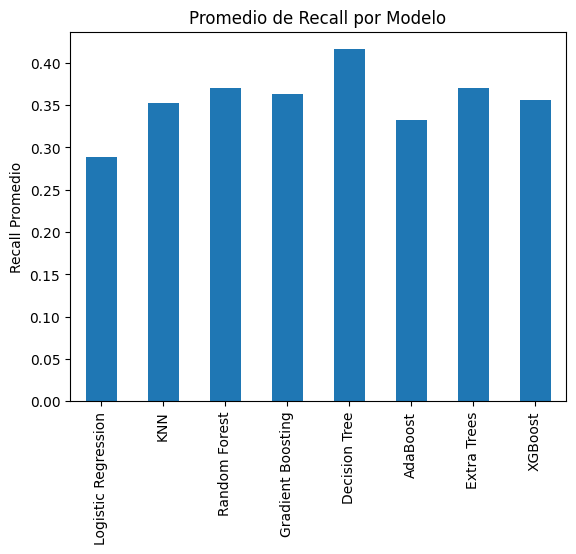

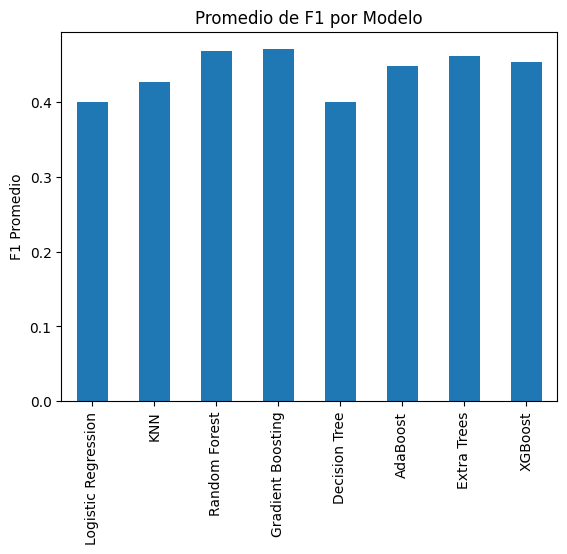

In [9]:
# Calcular promedios
auc_mean = auc_df.mean()
accuracy_mean = acc_df.mean()
precision_mean = prec_df.mean()
recall_mean = recall_df.mean()
f1_mean = f1_df.mean()

auc_mean.plot(kind='bar', title='Promedio de AUC por Modelo')
plt.ylabel('AUC Promedio')
plt.show()

accuracy_mean.plot(kind='bar', title='Promedio de Accuracy por Modelo')
plt.ylabel('Accuracy Promedio')
plt.show()

precision_mean.plot(kind='bar', title='Promedio de Precision por Modelo')
plt.ylabel('Precision Promedio')
plt.show()

recall_mean.plot(kind='bar', title='Promedio de Recall por Modelo')
plt.ylabel('Recall Promedio')
plt.show()

f1_mean.plot(kind='bar', title='Promedio de F1 por Modelo')
plt.ylabel('F1 Promedio')
plt.show()



Resultados destacados de la validación cruzada:
- Mejor AUC promedio: Gradient Boosting ≈ 0.781; AdaBoost ≈ 0.773; XGBoost ≈ 0.761; Random Forest ≈ 0.757.

## Test de Diferencias Críticas (Nemenyi)

Se aplica un análisis estadístico post-hoc (Nemenyi Test) con diagramas de diferencias críticas para determinar si las diferencias entre modelos son estadísticamente significativas.

In [ ]:
import scikit_posthocs as sp

def calcular_diferencias_criticas(df, metric_name):

    avg_rank = df.rank(axis=1).mean(axis=0)

    print(f"\n===== Ranks promedio para {metric_name} =====")
    print(avg_rank.sort_values())

    cd_result = sp.posthoc_nemenyi_friedman(df.values)

    plt.figure(figsize=(10, 6), dpi=300)
    plt.title(f'Diagrama de Diferencias Críticas ({metric_name})')
    
    try:
        sp.critical_difference_diagram(avg_rank, cd_result)
    except Exception:
        print("La función critical_difference_diagram no está disponible en tu instalación.")
    
    plt.show()


===== Ranks promedio para AUC =====
Decision Tree          1.0
KNN                    2.0
Extra Trees            3.0
Random Forest          4.6
Logistic Regression    5.2
XGBoost                5.2
AdaBoost               7.0
Gradient Boosting      8.0
dtype: float64


/Users/davidclemente/Dropbox/2025/Bluetab/bluetab-test/.venv/lib/python3.12/site-packages/scikit_posthocs/_plotting.py:528: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (x for x in crossbar_sets if len(x) > 1), key=lambda x: ranks[list(x)].min()
/Users/davidclemente/Dropbox/2025/Bluetab/bluetab-test/.venv/lib/python3.12/site-packages/scikit_posthocs/_plotting.py:549: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [ranks[i] for i in bar],


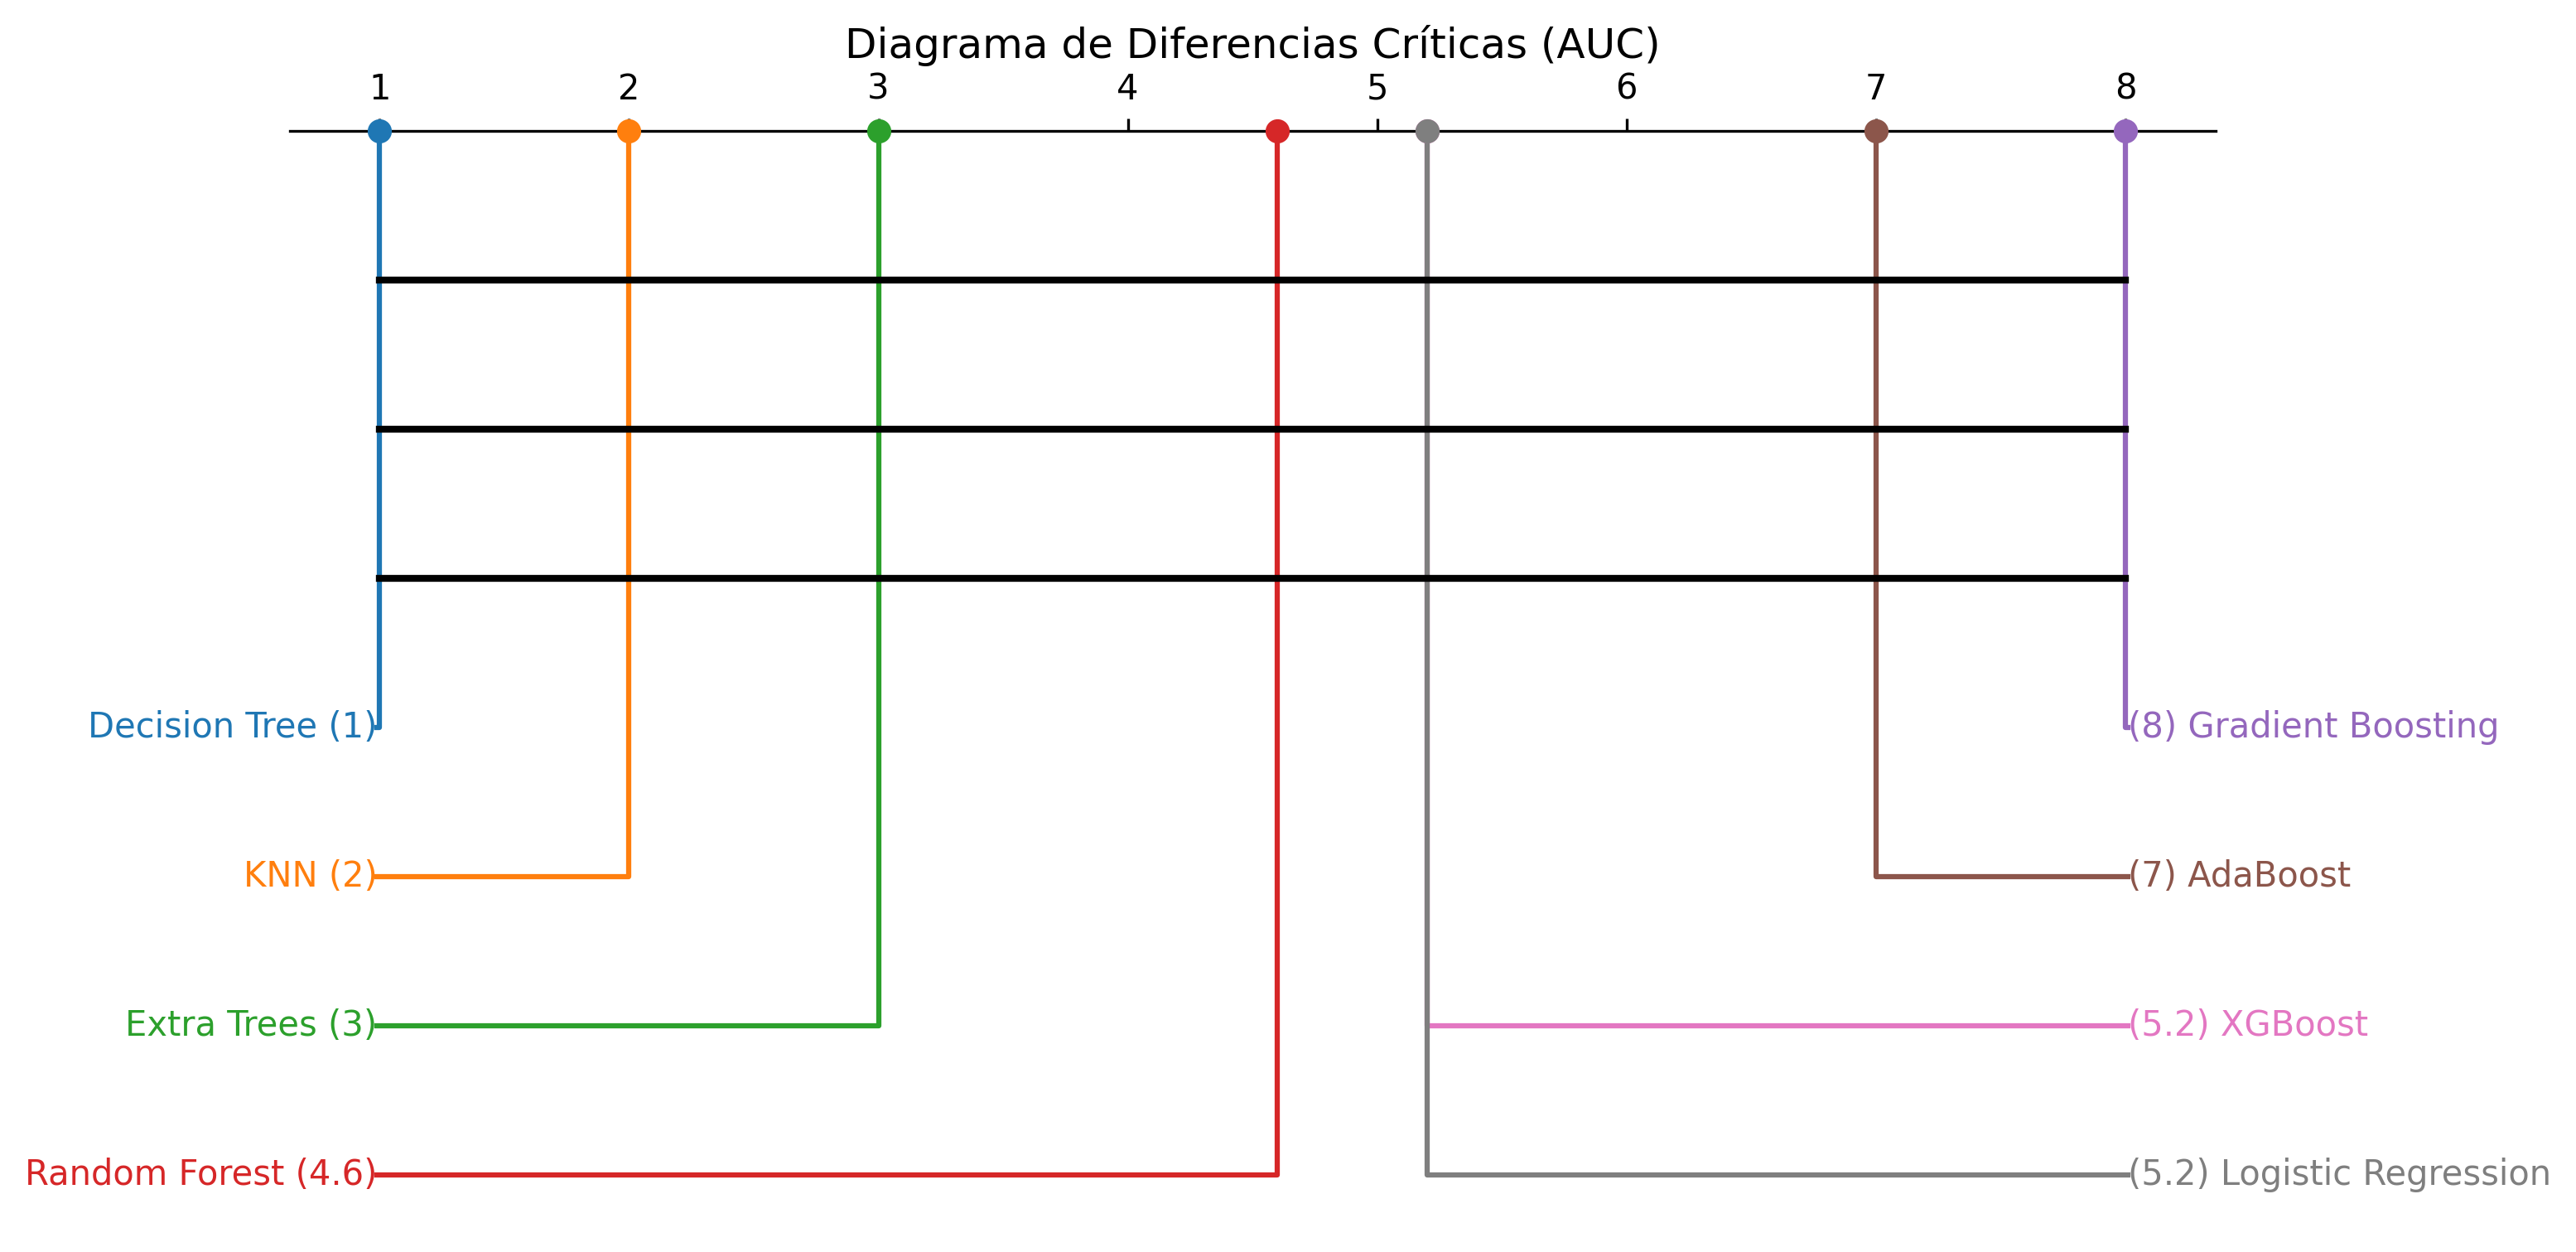


===== Ranks promedio para Accuracy =====
Decision Tree          1.0
KNN                    2.0
Extra Trees            3.8
Logistic Regression    4.2
XGBoost                4.2
Random Forest          5.8
AdaBoost               7.4
Gradient Boosting      7.6
dtype: float64


/Users/davidclemente/Dropbox/2025/Bluetab/bluetab-test/.venv/lib/python3.12/site-packages/scikit_posthocs/_plotting.py:528: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (x for x in crossbar_sets if len(x) > 1), key=lambda x: ranks[list(x)].min()
/Users/davidclemente/Dropbox/2025/Bluetab/bluetab-test/.venv/lib/python3.12/site-packages/scikit_posthocs/_plotting.py:549: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [ranks[i] for i in bar],


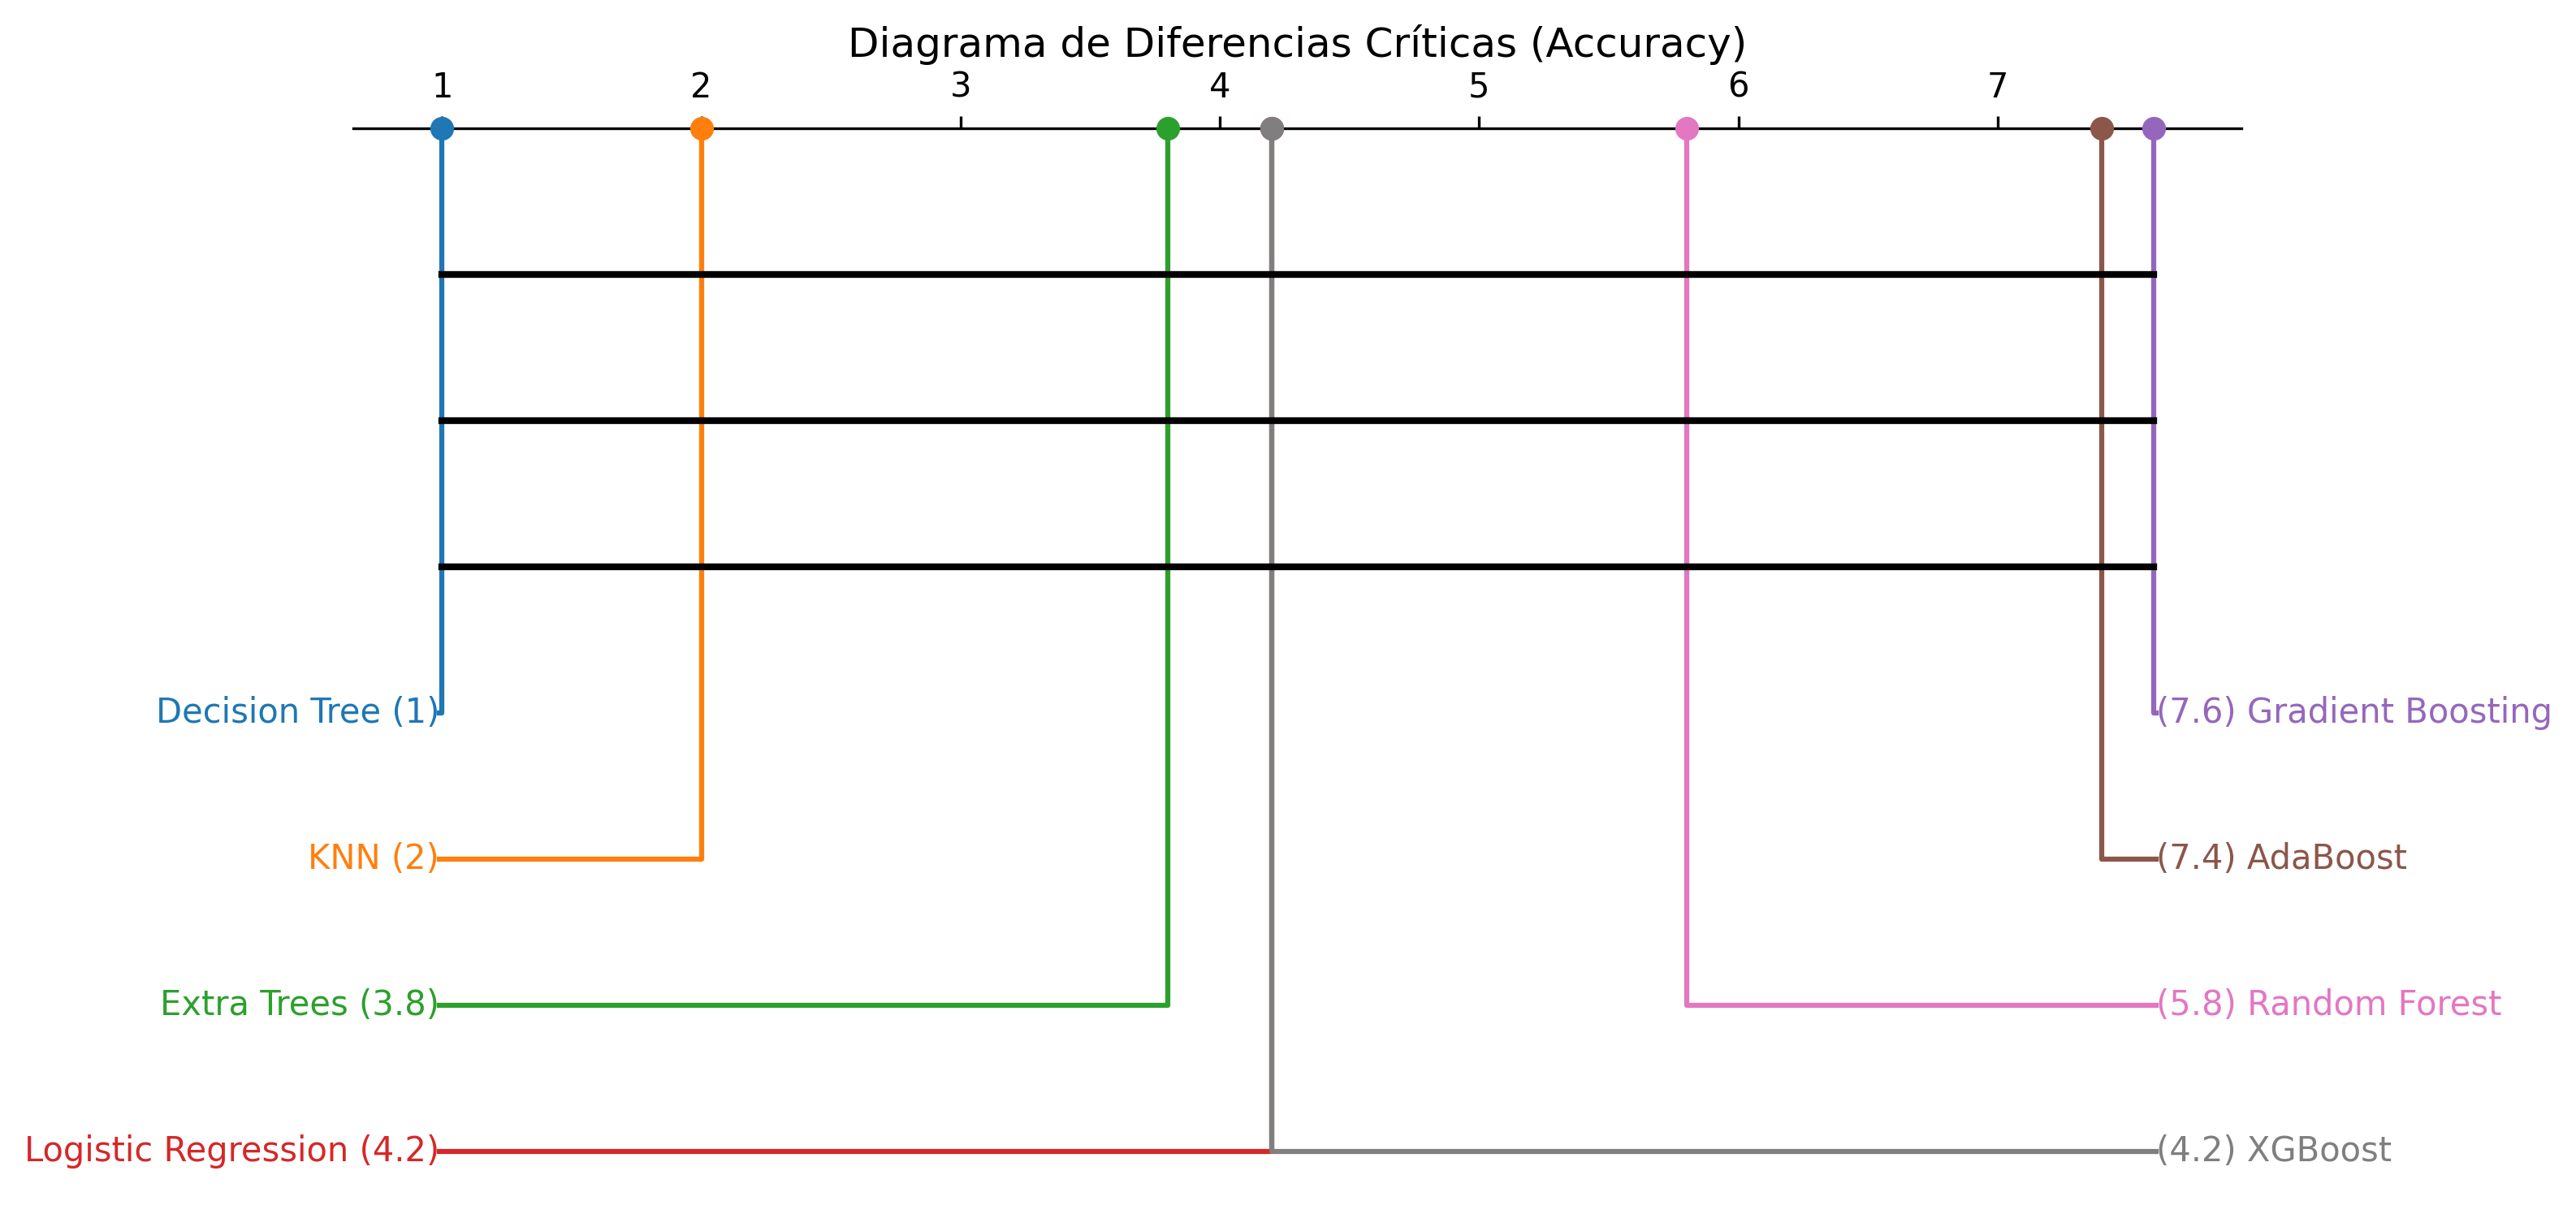


===== Ranks promedio para Precision =====
Decision Tree          1.0
KNN                    2.0
Extra Trees            3.4
XGBoost                3.8
Random Forest          5.0
Logistic Regression    6.0
Gradient Boosting      6.8
AdaBoost               8.0
dtype: float64


/Users/davidclemente/Dropbox/2025/Bluetab/bluetab-test/.venv/lib/python3.12/site-packages/scikit_posthocs/_plotting.py:528: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (x for x in crossbar_sets if len(x) > 1), key=lambda x: ranks[list(x)].min()
/Users/davidclemente/Dropbox/2025/Bluetab/bluetab-test/.venv/lib/python3.12/site-packages/scikit_posthocs/_plotting.py:549: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [ranks[i] for i in bar],


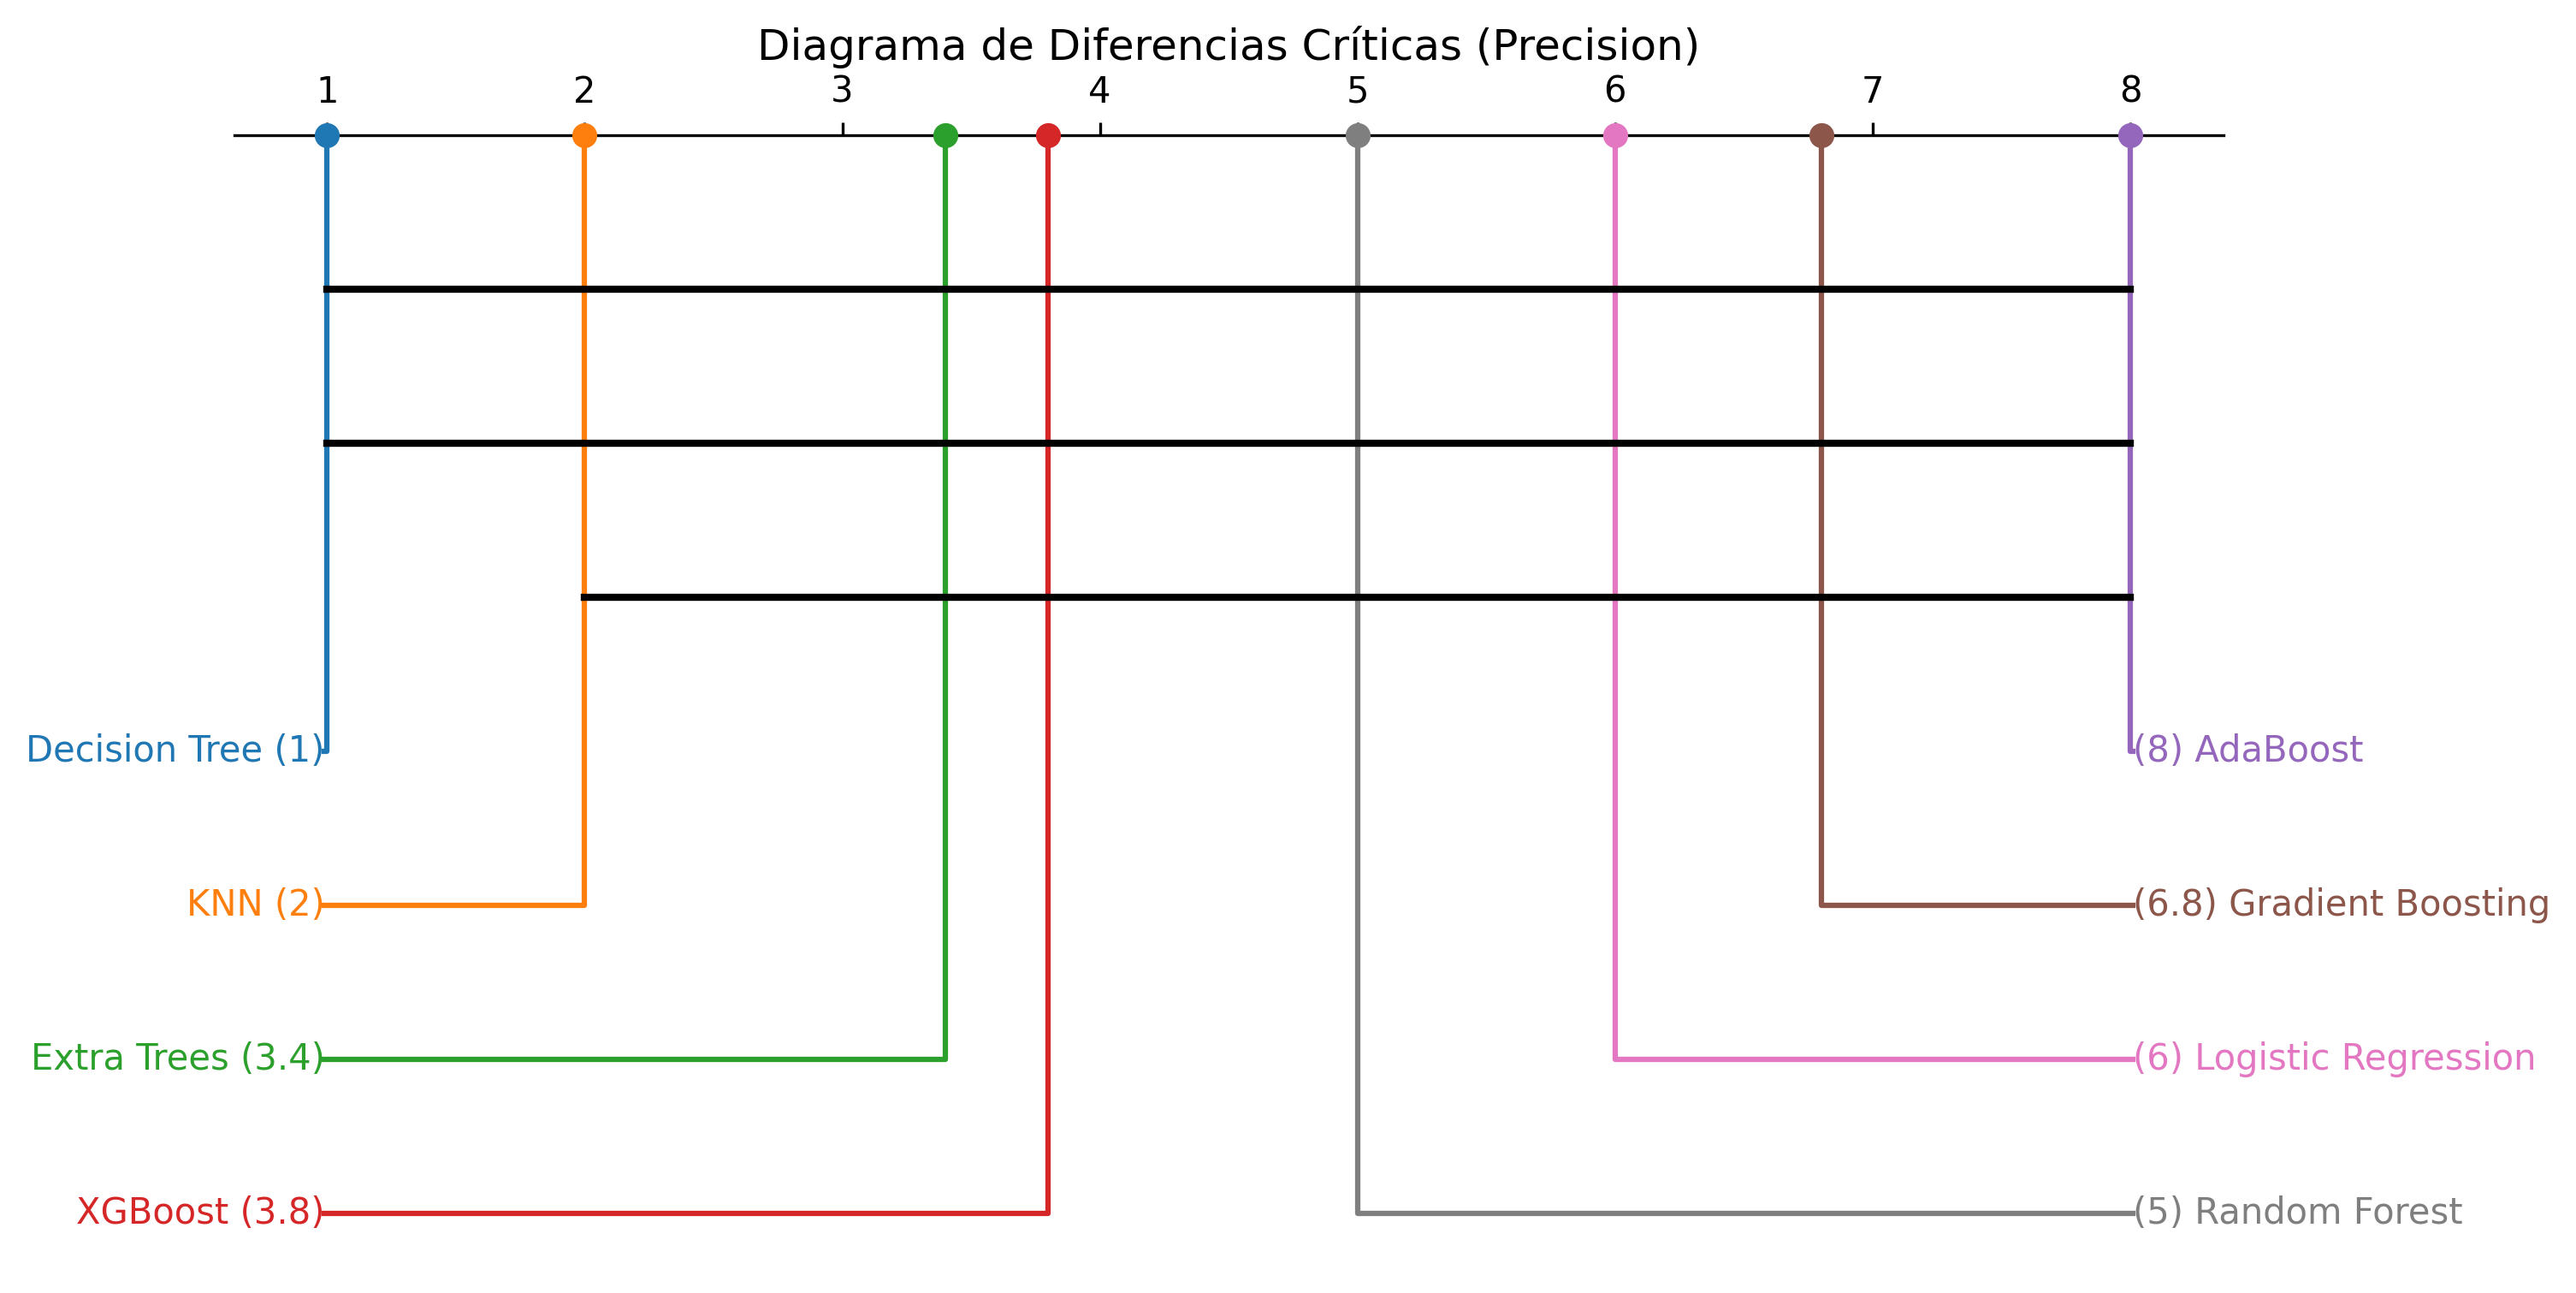


===== Ranks promedio para Recall =====
Logistic Regression    1.0
AdaBoost               2.0
KNN                    3.4
XGBoost                4.0
Gradient Boosting      5.4
Extra Trees            5.8
Random Forest          6.4
Decision Tree          8.0
dtype: float64


/Users/davidclemente/Dropbox/2025/Bluetab/bluetab-test/.venv/lib/python3.12/site-packages/scikit_posthocs/_plotting.py:528: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (x for x in crossbar_sets if len(x) > 1), key=lambda x: ranks[list(x)].min()
/Users/davidclemente/Dropbox/2025/Bluetab/bluetab-test/.venv/lib/python3.12/site-packages/scikit_posthocs/_plotting.py:549: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [ranks[i] for i in bar],


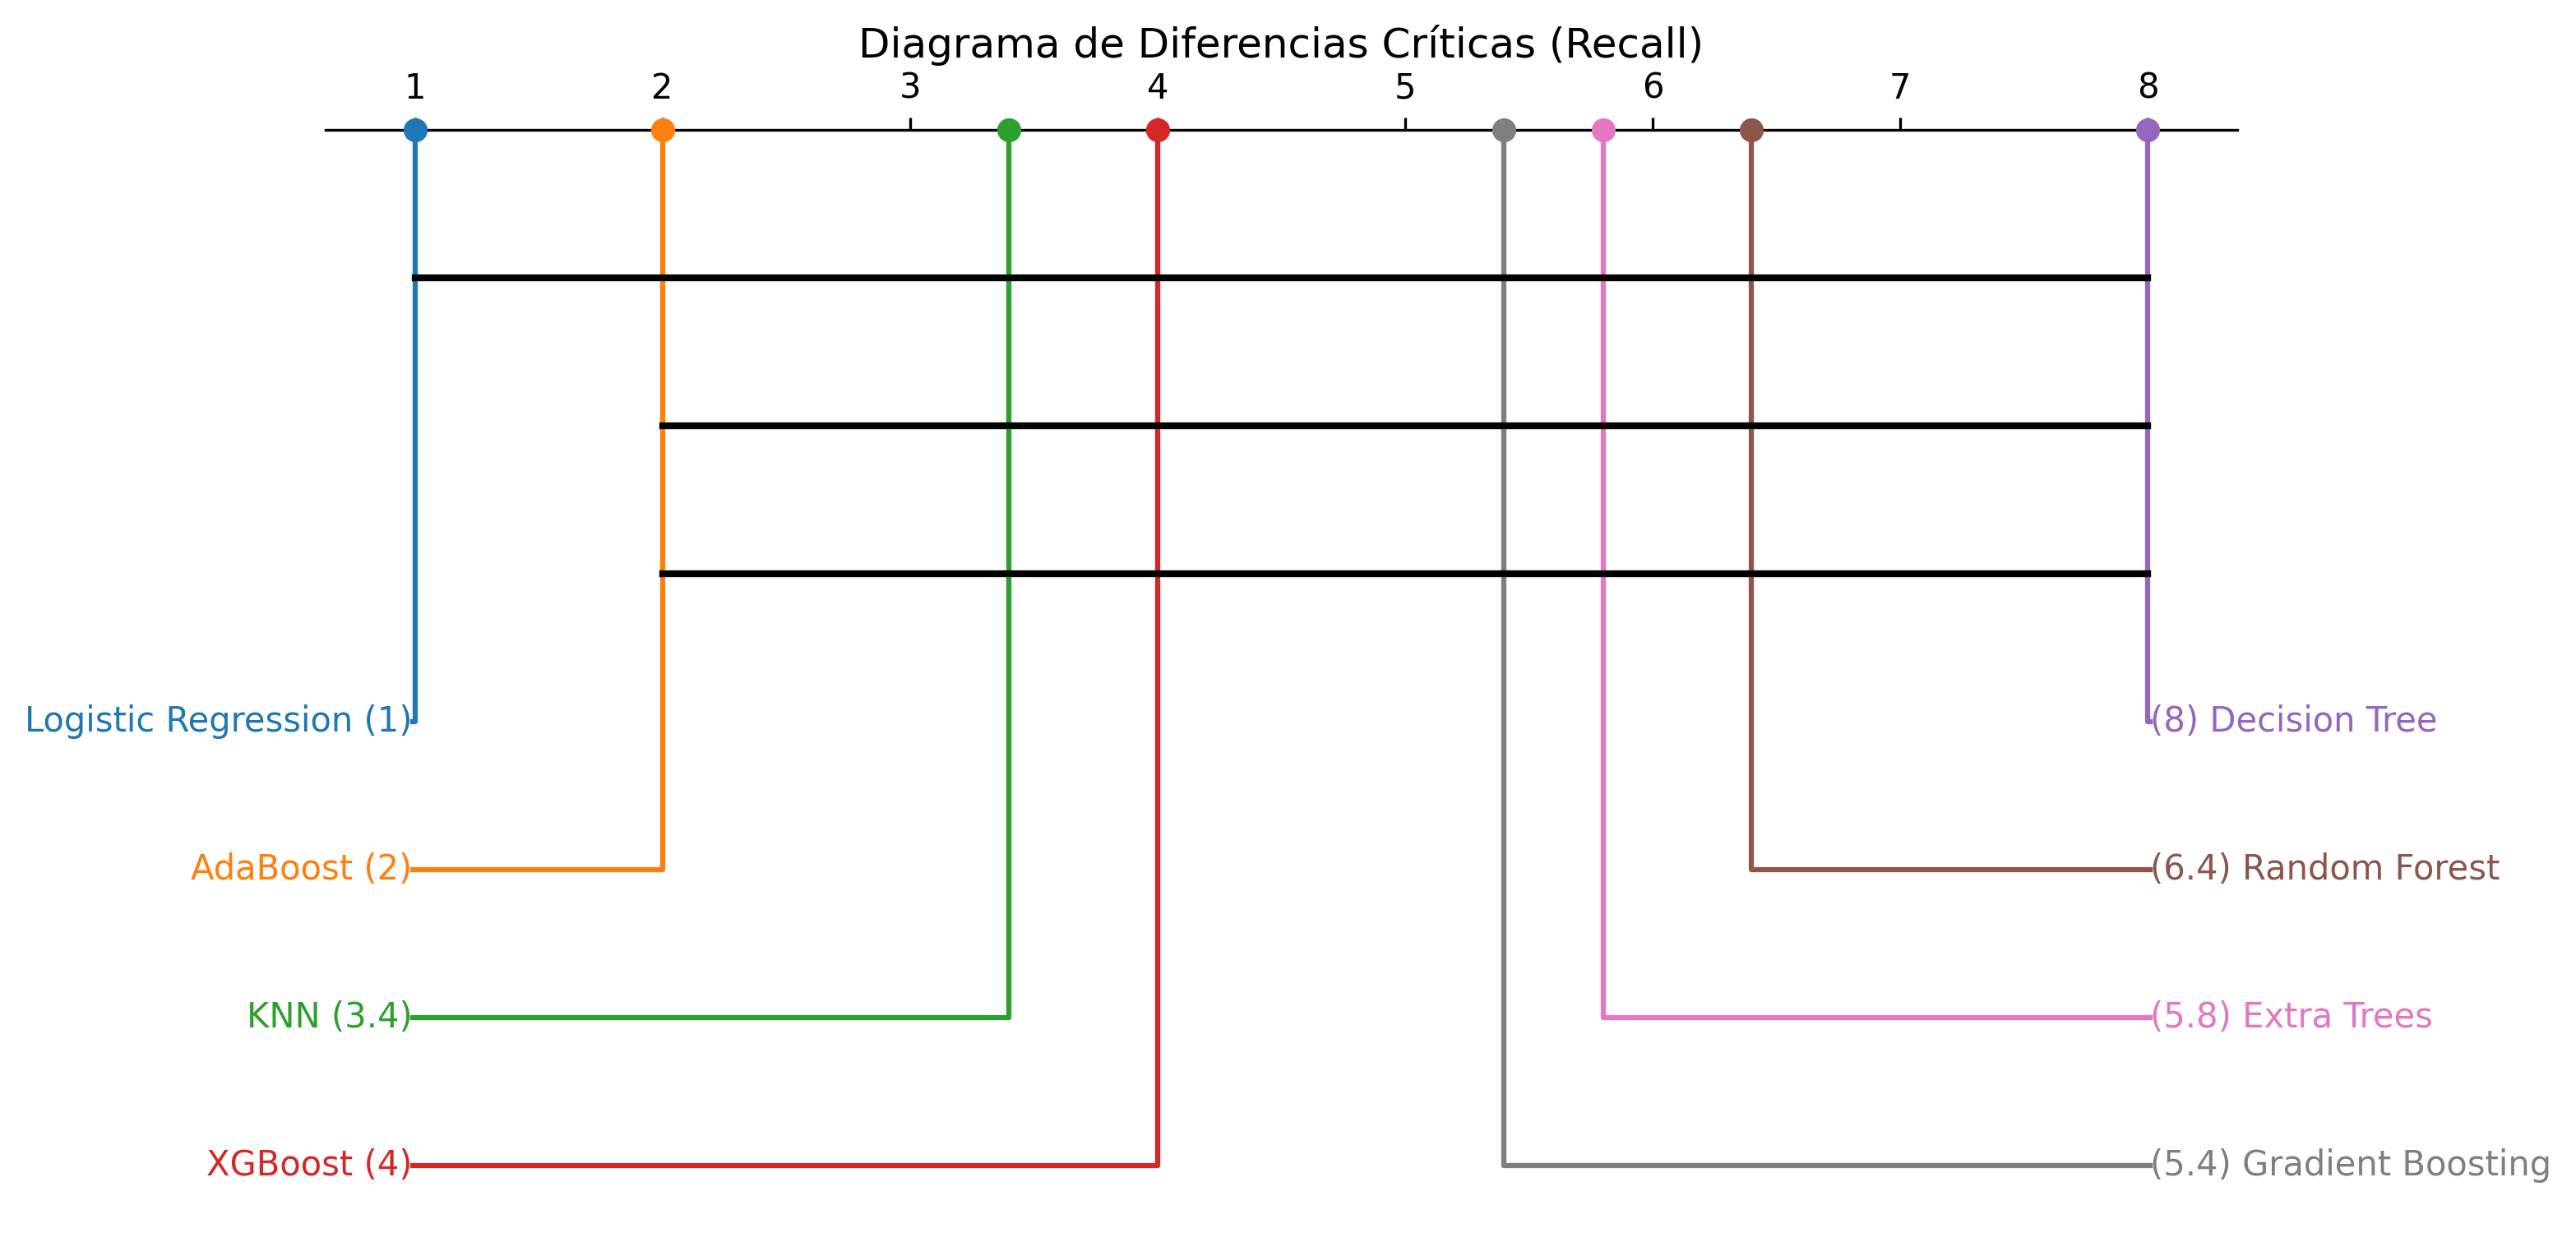


===== Ranks promedio para F1 =====
Logistic Regression    1.4
Decision Tree          1.6
KNN                    3.2
AdaBoost               4.2
XGBoost                5.0
Extra Trees            6.2
Random Forest          7.0
Gradient Boosting      7.4
dtype: float64


/Users/davidclemente/Dropbox/2025/Bluetab/bluetab-test/.venv/lib/python3.12/site-packages/scikit_posthocs/_plotting.py:528: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (x for x in crossbar_sets if len(x) > 1), key=lambda x: ranks[list(x)].min()
/Users/davidclemente/Dropbox/2025/Bluetab/bluetab-test/.venv/lib/python3.12/site-packages/scikit_posthocs/_plotting.py:549: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  [ranks[i] for i in bar],


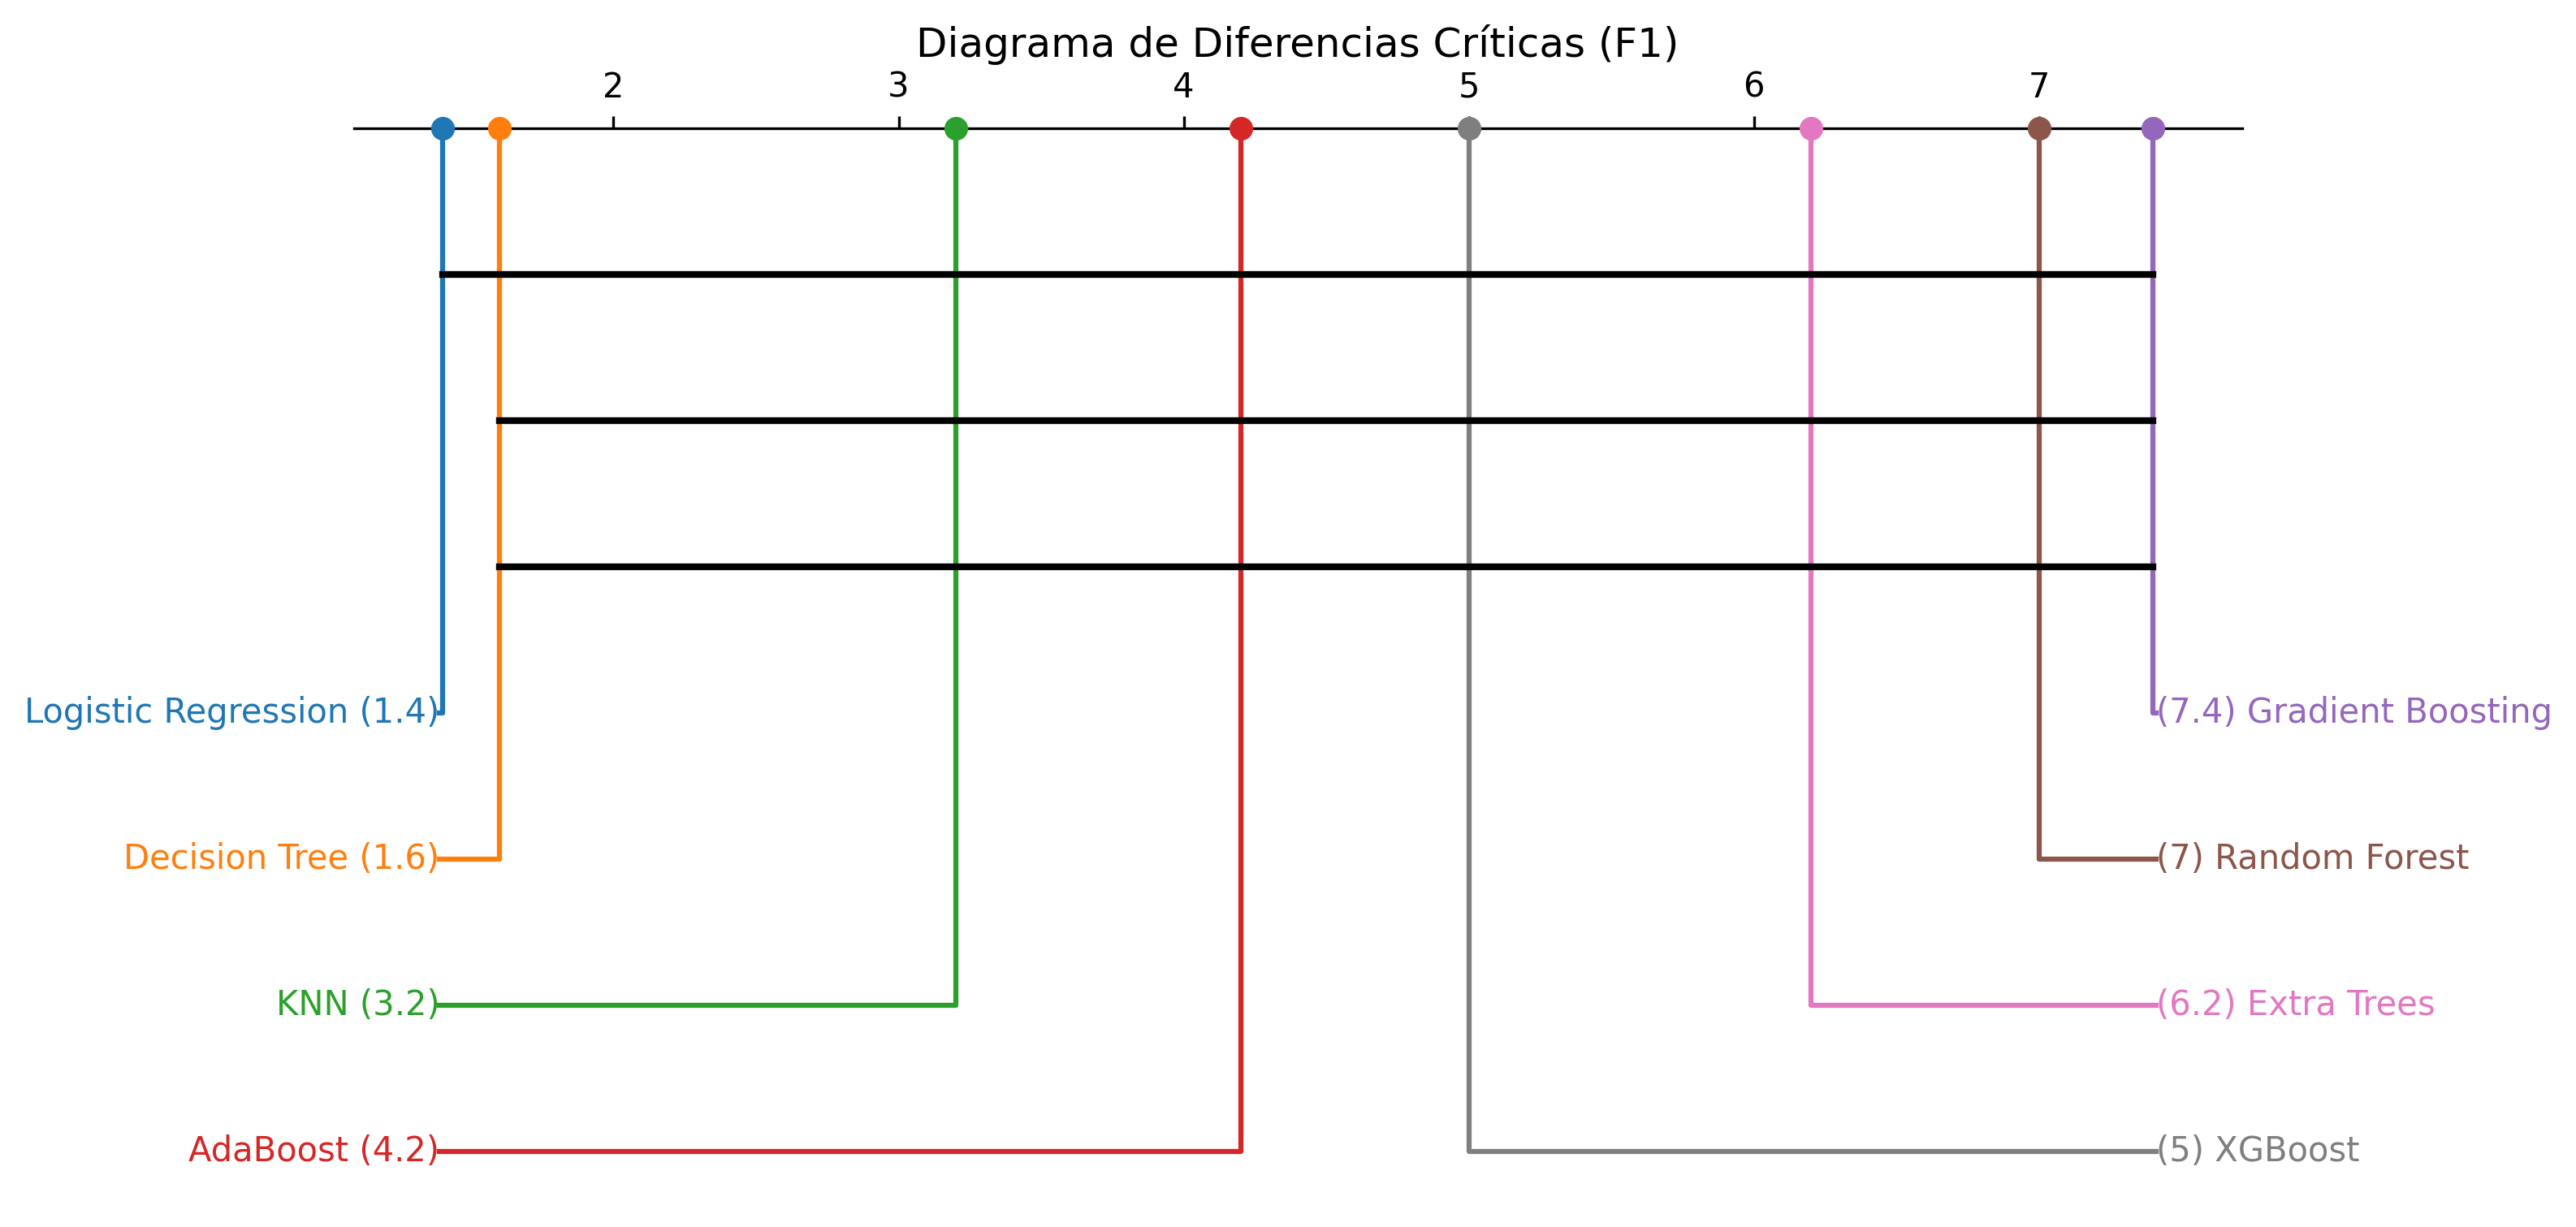

In [13]:
calcular_diferencias_criticas(auc_df, "AUC")
calcular_diferencias_criticas(acc_df, "Accuracy")
calcular_diferencias_criticas(prec_df, "Precision")
calcular_diferencias_criticas(recall_df, "Recall")
calcular_diferencias_criticas(f1_df, "F1")

In [14]:
from sklearn.model_selection import KFold, cross_val_score

# Definir modelo
gbc = GradientBoostingClassifier(random_state=42)

# Definir métricas
scoring = {
    'AUC': 'roc_auc',
    'Accuracy': make_scorer(accuracy_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'F1': make_scorer(f1_score)
}


# Validación cruzada
cv = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for metric_name, metric in scoring.items():
    scores = cross_val_score(gbc, X, y, cv=cv, scoring=metric)
    results[metric_name] = [scores.mean(), scores.std()]

# Resultados en DataFrame
results_df = pd.DataFrame(results, index=['Mean', 'Std']).T
print(results_df)

               Mean       Std
AUC        0.780687  0.004241
Accuracy   0.820900  0.003901
Precision  0.675687  0.017600
Recall     0.366633  0.011080
F1         0.475091  0.008204


In [15]:
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X, y)

y_pred = gbc.predict(X)
y_proba = gbc.predict_proba(X)[:, 1]  

metrics = {
    "Accuracy": accuracy_score(y, y_pred),
    "Precision": precision_score(y, y_pred),
    "Recall": recall_score(y, y_pred),
    "F1": f1_score(y, y_pred),
    "AUC": roc_auc_score(y, y_proba)
}

metrics_df = pd.DataFrame(metrics, index=[0])
print(metrics_df)

   Accuracy  Precision    Recall        F1       AUC
0  0.826267   0.697121  0.379445  0.491413  0.802373


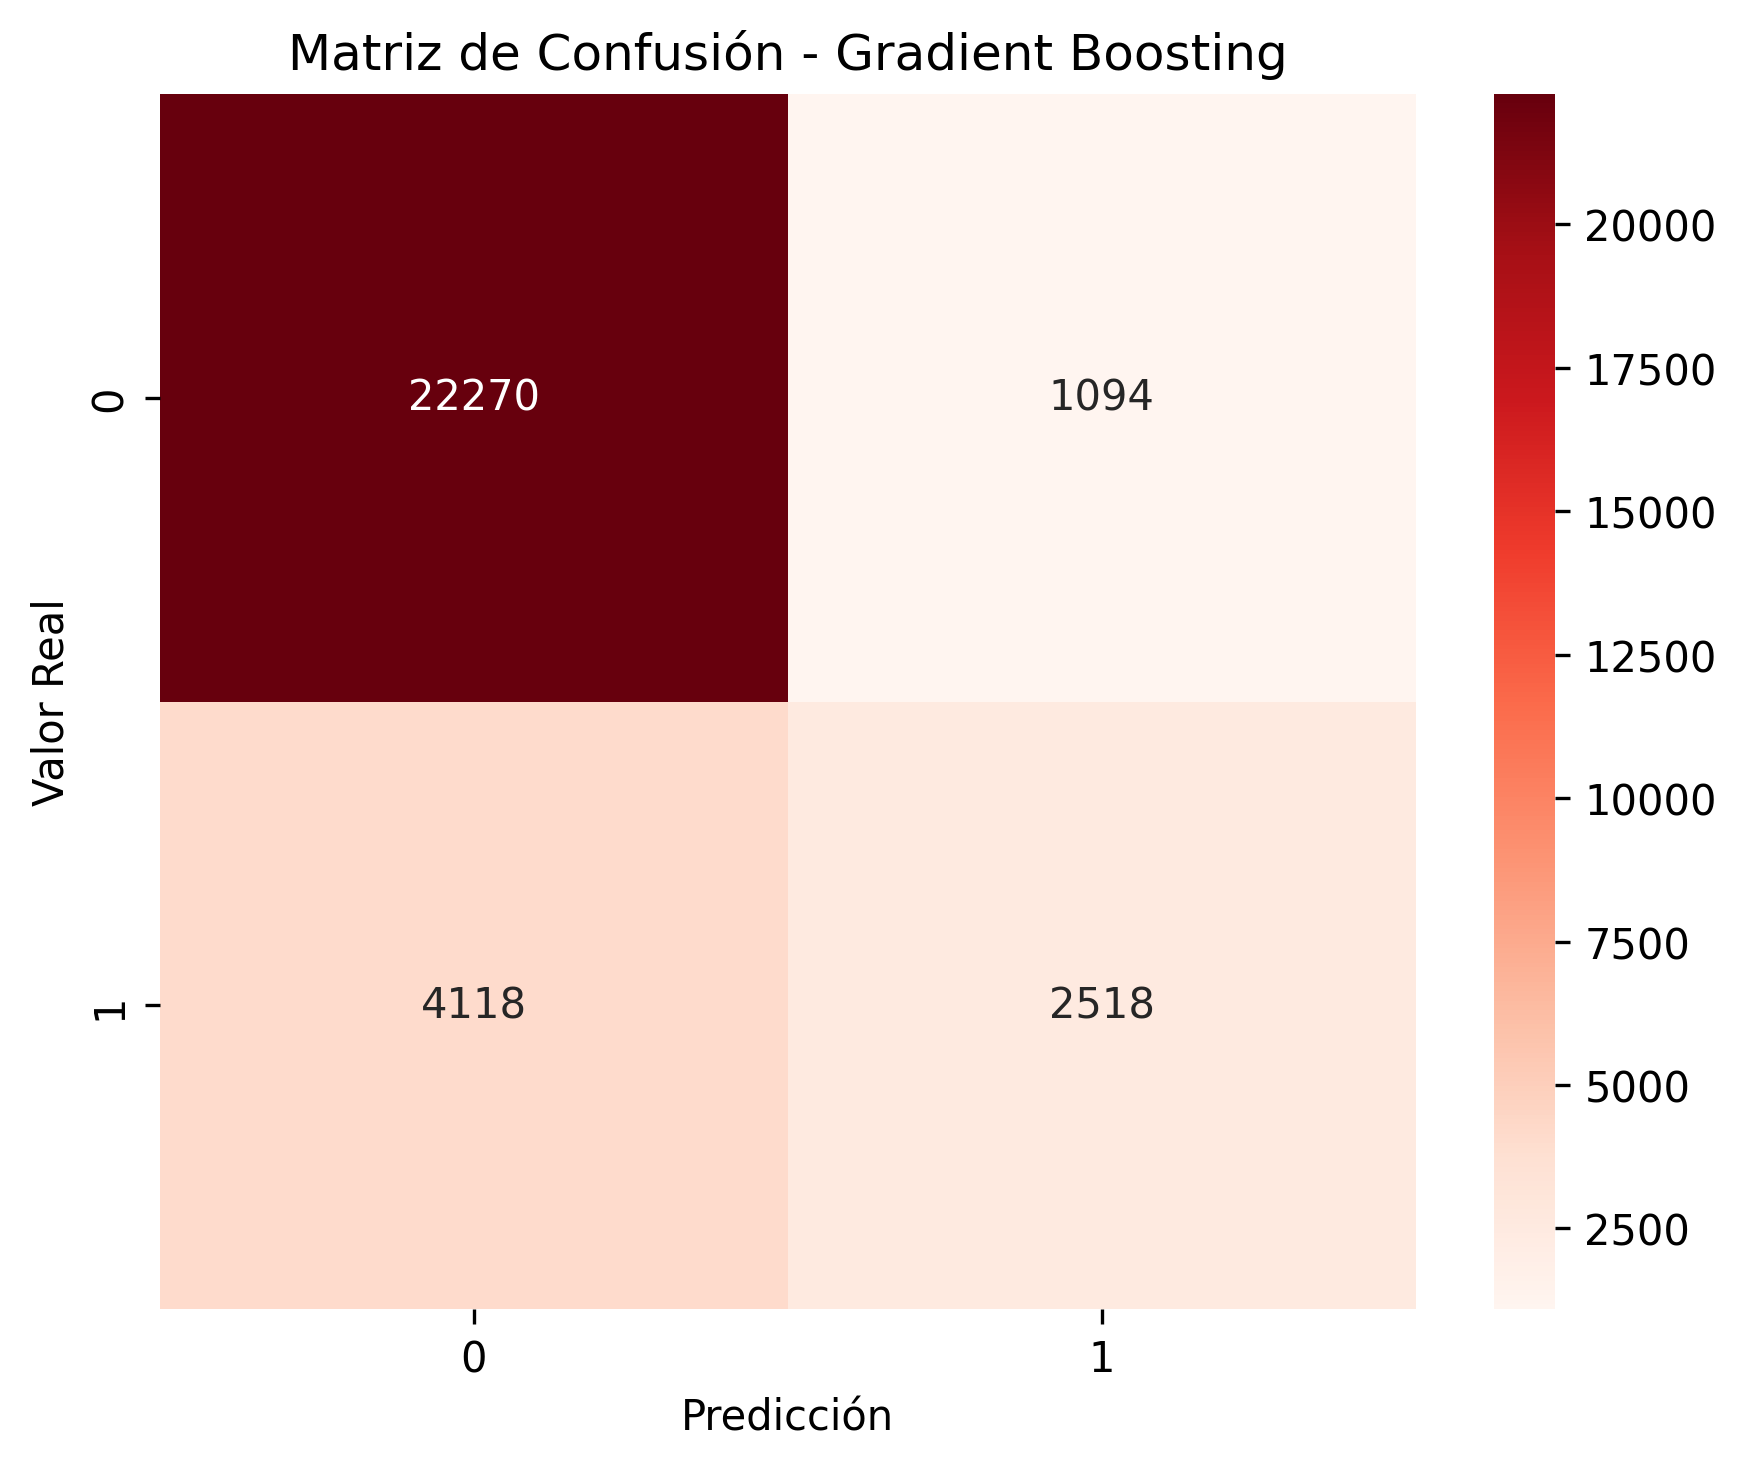

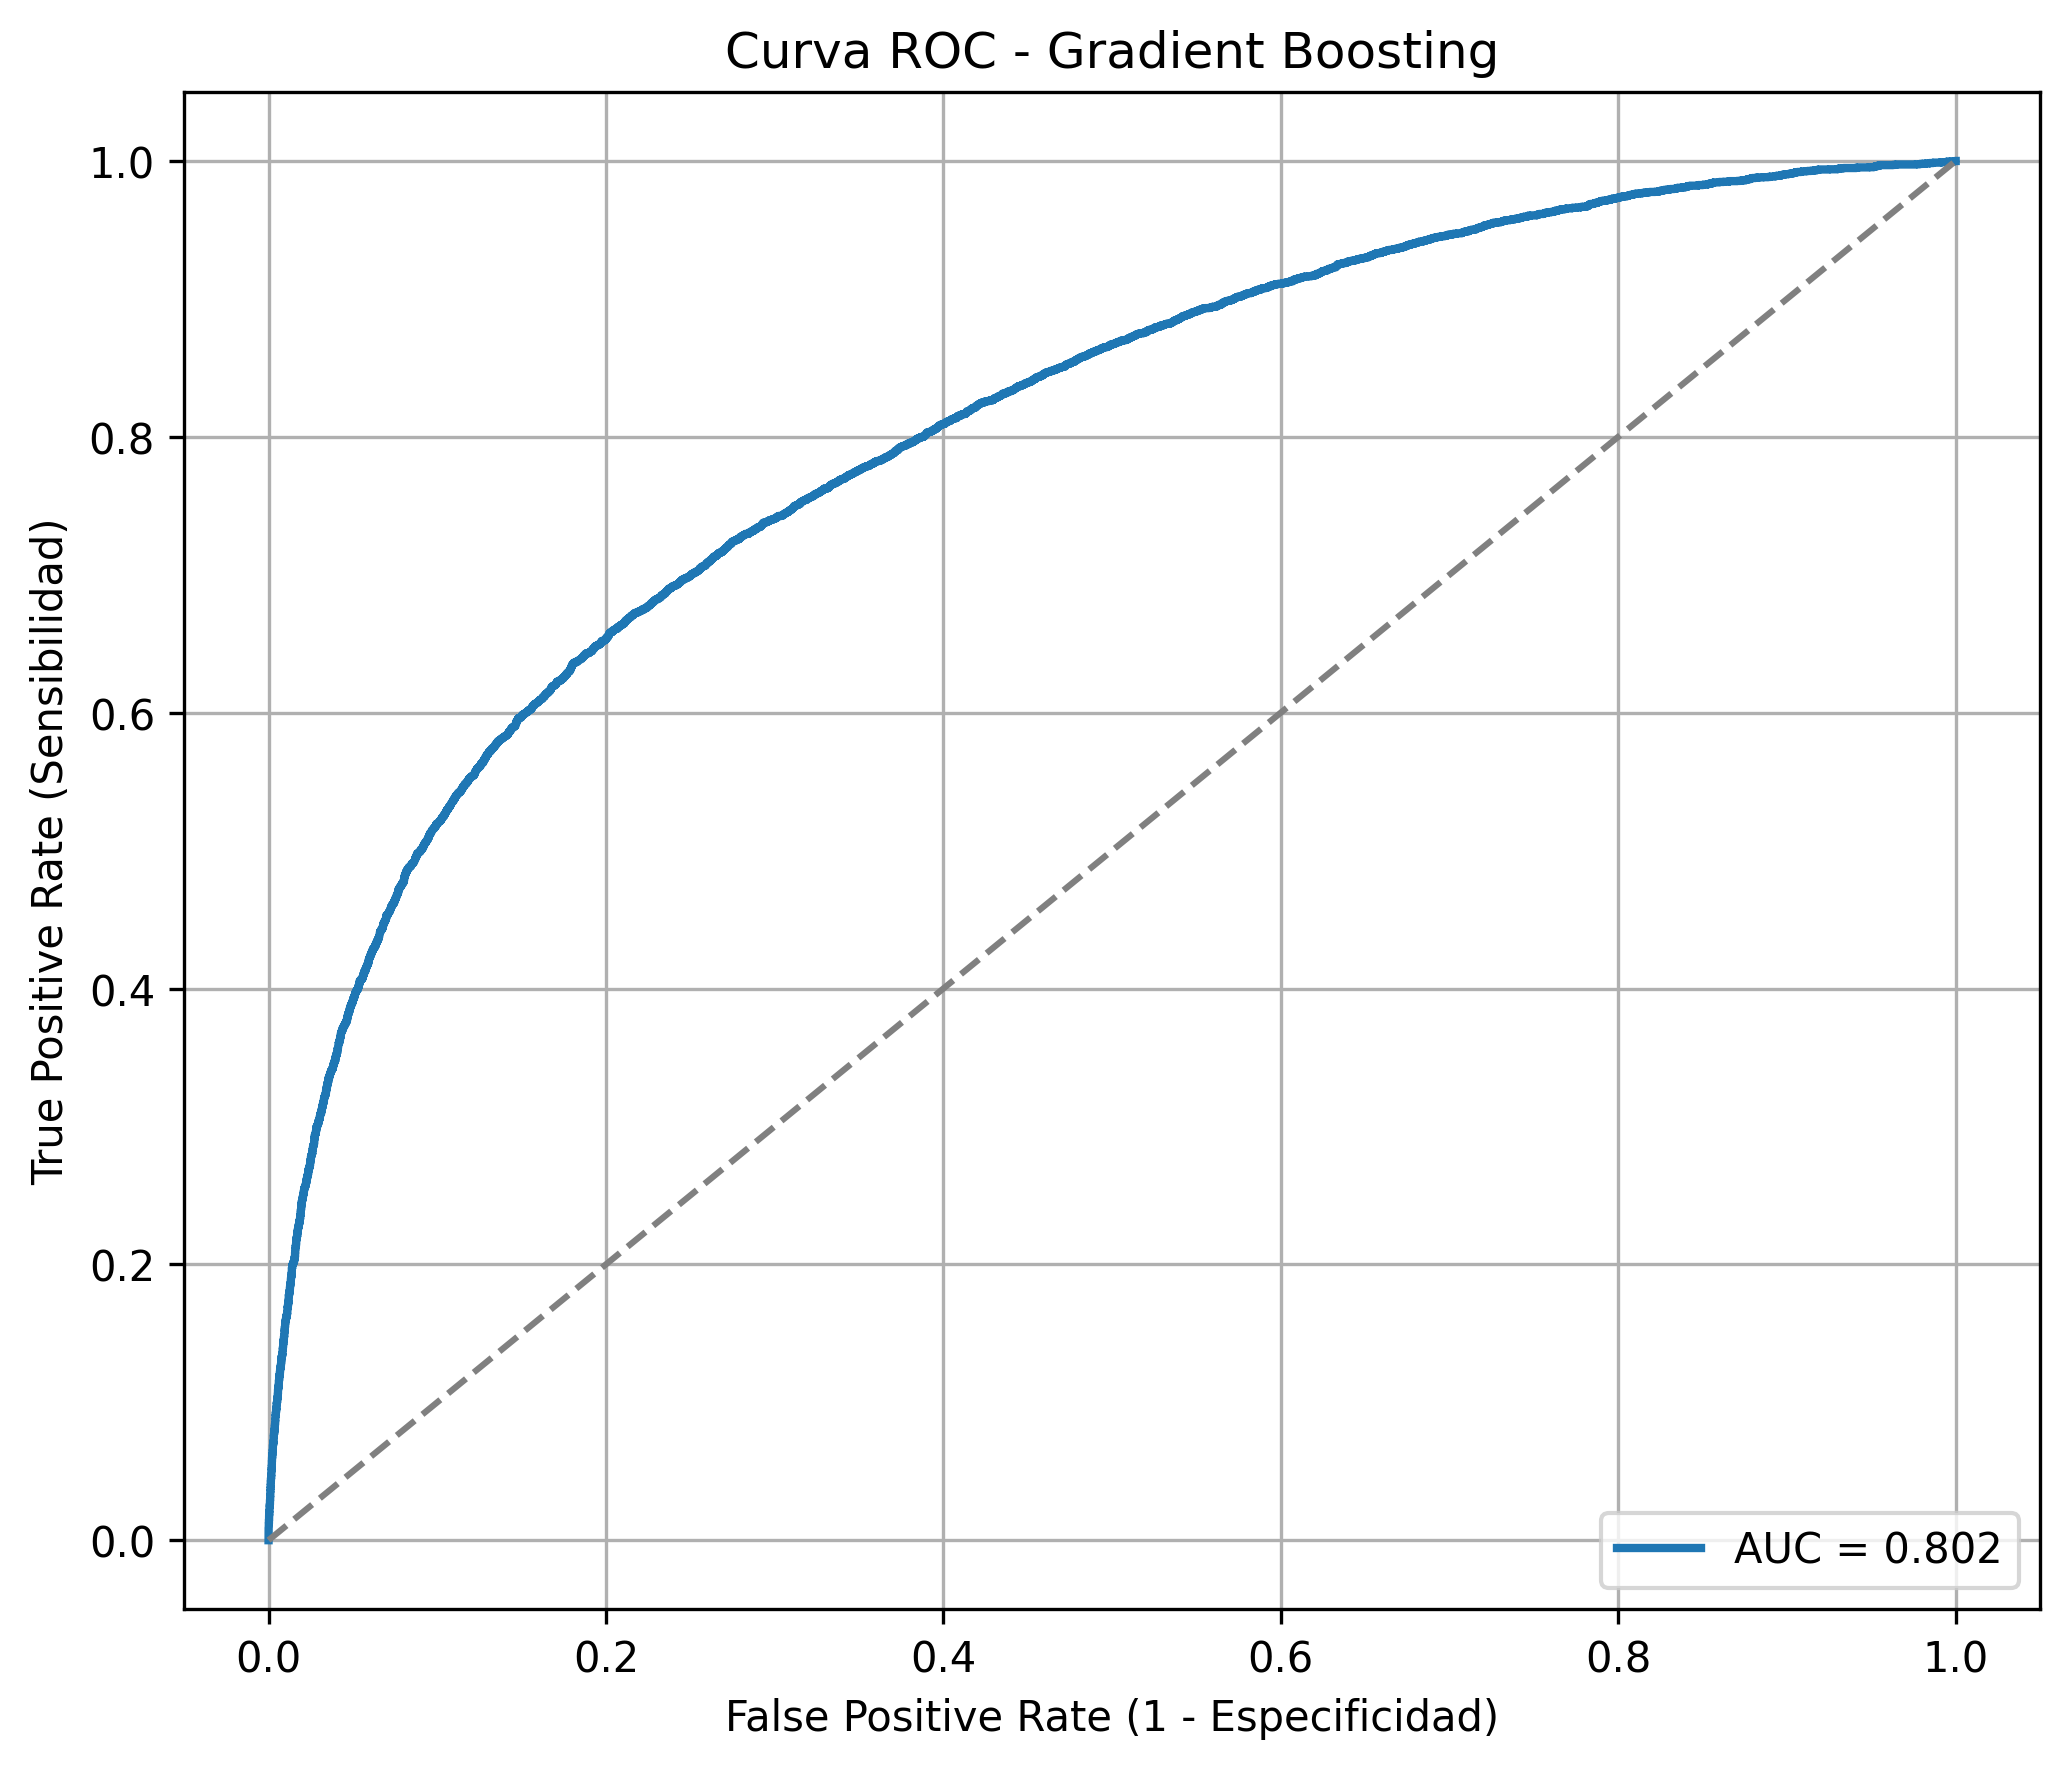

In [22]:
cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(6, 5), dpi=300)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title("Matriz de Confusión - Gradient Boosting")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.tight_layout()
plt.show()

fpr, tpr, thresholds = roc_curve(y, y_proba)
auc_value = roc_auc_score(y, y_proba)

plt.figure(figsize=(7, 6), dpi=300)
plt.plot(fpr, tpr, label=f"AUC = {auc_value:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.title("Curva ROC - Gradient Boosting")
plt.xlabel("False Positive Rate (1 - Especificidad)")
plt.ylabel("True Positive Rate (Sensibilidad)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

## Consideraciones

- Dataset: 30 000 filas, 25 columnas, default rate 22.12 %. Countplots por sexo, educación y matrimonio; histogramas de `AGE` y `LIMIT_BAL`; boxplots de montos vs. default; correlaciones de pagos y bills con la etiqueta (negativas y débiles).
- Limpieza: renombrado del target a `default`, recodificación de educación (0/5/6→4) y matrimonio (0→3); winsorize al 1 % en bills/pagos; nulos a 0.
- Features finales: `PAY_0/2/3/4/5/6`, `BILL_AMT2-6`, `PAY_AMT2-6`, sumatoria/conteo/máximo de retrasos, ratios de pago por mes 2–6 y agregados (promedio/mín/máx), tendencias `bill_trend` (BILL_AMT2−BILL_AMT6) y `pay_trend` (PAY_AMT2−PAY_AMT6).
- Modelado: Logistic Regression y KNN (con escalado) más árboles (Random Forest, Gradient Boosting, Decision Tree, AdaBoost, Extra Trees, XGBoost). CV 5-fold: mejores AUC promedio Gradient Boosting 0.781, AdaBoost 0.773, XGBoost 0.761, Random Forest 0.757; rankings con Nemenyi.
- Validación cruzada para Gradient Boosting: AUC 0.7807±0.0042, Accuracy 0.8209±0.0039, Precision 0.6757±0.0176, Recall 0.3666±0.0111, F1 0.4751±0.0082. Entrenado en todo el dataset: Accuracy 0.826, Precision 0.697, Recall 0.379, F1 0.491, AUC 0.802; incluye matriz de confusión y curvas ROC/PR.